# Support Vector Machine

#### a) Train an SVM classifier for the 3D Shapes dataset. Please use the features you extracted in the first assignment. You may also extract new features if you want. There are 15 unique orientations that will be considered as 15 classes. You may use scikit-learn’s SVM function in this question. <br>
* Train an SVM classifier for a binary classification problem by choosing two orientations
as the classes.<br>
* Train an SVM classifier for 15 class classification problem. <br>
* Compare the performances of 2 and 15 class classification with the same hyperparameters. Please discuss the reasons why their performances differ.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime    # for measuring time
from skimage.feature import hog  # HOG feature descriptor

In [9]:
DATA = "../assignment1/data2/linearRegression_data/"
SHAPE_TRAIN = "3dshapes_train"
SHAPE_TEST = "3dshapes_test"
ORIENTATIONS_TRAIN = "orientations_train.npy"
ORIENTATIONS_TEST = "orientations_test.npy"

In [10]:
def load_npy_file(data_dir: str, file_name: str) -> np.array:
    return np.load(f"{data_dir}/{file_name}")

def load_data(data_dir, shape_dir, orientations_dir, size):
    image_list = [] # store images in the memory
    for i in range(size):
        filename = f"{data_dir}/{shape_dir}/{i}.jpg"
        im=Image.open(filename)
        image_list.append(np.array(im.convert('L')))   
    
    orientations = load_npy_file(data_dir, orientations_dir)
    return np.array(image_list), np.array(orientations)

In [11]:
# loading the data may take some time (it took ~3 minutes on my machine)
X_train, y_train = load_data(DATA, SHAPE_TRAIN, ORIENTATIONS_TRAIN, size = 10000)
X_test, y_test = load_data(DATA, SHAPE_TEST, ORIENTATIONS_TEST, size = 1000)

X_train.shape, y_train.shape, X_test.shape, y_test.shape
# ((10000, 64, 64), (10000,), (1000, 64, 64), (1000,))

((10000, 64, 64), (10000,), (1000, 64, 64), (1000,))

In [12]:
len(np.unique(y_train)) # 15 

15

##### Train an SVM classifier for a binary classification problem by choosing two orientations.

In [13]:
# cluster 15 classes into two
# first find the mean 
mean = np.mean(y_train)

# copy
y_train_binary = y_train.copy()
y_test_binary = y_test.copy()

# then assign the labels
y_train_binary[y_train_binary < mean] = 0
y_train_binary[y_train_binary >= mean] = 1

y_test_binary[y_test_binary < mean] = 0
y_test_binary[y_test_binary >= mean] = 1

print("Training set:\n \tOrientations labeled as 1: ", y_train_binary.sum(), "\n \tOrientations labeled as 0: ", len(y_train_binary) - y_train_binary.sum())
print("Test set:\n \tOrientations labeled as 1: ", y_test_binary.sum(), "\n \tOrientations labeled as 0: ", len(y_test_binary) - y_test_binary.sum())

Training set:
 	Orientations labeled as 1:  4664.0 
 	Orientations labeled as 0:  5336.0
Test set:
 	Orientations labeled as 1:  494.0 
 	Orientations labeled as 0:  506.0


In [14]:
def extract_HOG_features(images, orientations=9, pixels_per_cell=(8, 8)):
    hog_images = np.array([hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
						cells_per_block=(3, 3)) for img in images])
    return hog_images

X_train_HOG = extract_HOG_features(X_train)
X_test_HOG = extract_HOG_features(X_test)

X_train_HOG.shape, X_test_HOG.shape
# 54 x 54 = 2916
# ((10000, 2916), (1000, 2916))  

((10000, 2916), (1000, 2916))

* SVM formulation:

$$
\mathcal{E}_n: \textbf{margin violation for each data point}  \;\;(x_n, y_n) \\
\min_{w,b,\mathcal{E}} \;\; \frac{1}{2}w^T w + C \sum_{n=1}^{N}{\mathcal{E}_n} \\
\text{s.t.} \;\; y_n (w^T x_n) \geq 1 - \mathcal{E}_n \;\; \text{for} \;\; n = 1, 2, ..., N \\
 \mathcal{E}_n \geq0 \;\;\;\;\;\; \text{for} \;\; n = 1, 2, ..., N  \\
$$




* There is no direct implementation of hard-margin or soft-margin SVM in scikit-learn. However, we can get a hard-margin SVM by setting `C` to be extremely large number (e.g. 1000) so that it leads to a higher penalization on margin violation $\epsilon_n$. To make it a soft-margin SVM, we can set `C` to be a smaller number (e.g. 0.1) so that it leads to a lower penalization on margin violation $\epsilon_n$.

In [16]:
# apply svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def apply_SVM(X_train: np.array, 
              y_train: np.array, 
              X_test: np.array, 
              y_test: np.array, 
              type: str,
              svm: SVC,
              time_acc = None):
    time = datetime.now()
    print("-"*50)
    print(f"Training {type} SVM...")
    svm.fit(X_train, y_train)

    execution_time = datetime.now() - time
    print(f"Training time: {execution_time}")
    y_pred = svm.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: ", acc)
    if(time_acc is not None):
        time_acc[type] = (round(execution_time.total_seconds(), 2), acc)

In [17]:
svm_types = {
    "hard-margin linear": SVC(C = 1000, kernel="linear"),
    "soft-margin linear": SVC(C = 0.1, kernel="linear"),
    "hard-margin rbf": SVC(C = 1000, kernel="rbf", gamma="scale"),
    "soft-margin rbf": SVC(C = 0.1, kernel="rbf", gamma="scale"),
    "hard-margin poly": SVC(C = 1000, kernel="poly", gamma="scale"),
    "soft-margin poly": SVC(C = 0.1, kernel="poly", gamma="scale")
}

In [18]:
# apply different SVMs for binary classification
for type, svm in svm_types.items():
    apply_SVM(X_train_HOG, y_train_binary, X_test_HOG, y_test_binary, type, svm)

--------------------------------------------------
Training hard-margin linear SVM...
Training time: 0:00:19.185592
Accuracy:  1.0
--------------------------------------------------
Training soft-margin linear SVM...
Training time: 0:00:42.777719
Accuracy:  1.0
--------------------------------------------------
Training hard-margin rbf SVM...
Training time: 0:00:25.470742
Accuracy:  1.0
--------------------------------------------------
Training soft-margin rbf SVM...
Training time: 0:02:00.815705
Accuracy:  0.992
--------------------------------------------------
Training hard-margin poly SVM...
Training time: 0:00:12.214175
Accuracy:  1.0
--------------------------------------------------
Training soft-margin poly SVM...
Training time: 0:00:43.350629
Accuracy:  0.999


##### Train an SVM classifier for 15 class classification problem.

In [19]:
# map orientations to categorical int values (for SVM)
y_train_cat = y_train.copy()
y_test_cat = y_test.copy()

for i, orientation in enumerate(np.unique(y_train)):
    y_train_cat[y_train_cat == orientation] = i
    y_test_cat[y_test_cat == orientation] = i

y_train[:10], y_train_cat[:10]

(array([ 12.85714286, -12.85714286, -25.71428571,   4.28571429,
         -4.28571429,  30.        , -30.        ,  25.71428571,
         25.71428571,   0.        ]),
 array([10.,  4.,  1.,  8.,  6., 14.,  7., 13., 13.,  7.]))

In [20]:
time_acc = {}
for type, svm in svm_types.items():
    apply_SVM(X_train_HOG, y_train_cat, X_test_HOG, y_test_cat, type, svm, time_acc)

--------------------------------------------------
Training hard-margin linear SVM...
Training time: 0:00:31.888855
Accuracy:  1.0
--------------------------------------------------
Training soft-margin linear SVM...
Training time: 0:00:45.271963
Accuracy:  0.999
--------------------------------------------------
Training hard-margin rbf SVM...
Training time: 0:01:03.708464
Accuracy:  1.0
--------------------------------------------------
Training soft-margin rbf SVM...
Training time: 0:03:43.677901
Accuracy:  0.899
--------------------------------------------------
Training hard-margin poly SVM...
Training time: 0:01:11.001550
Accuracy:  1.0
--------------------------------------------------
Training soft-margin poly SVM...
Training time: 0:01:54.549854
Accuracy:  0.984


##### Compare the performances of 2 and 15 class classification with the same hyperparameters. Please discuss the reasons why their performances differ.

* As it can be seen from the outputs, amount of time required for 2 class classification is much less than 15 class classification. According to the documentation, [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) and [NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC) implement the “one-versus-one” approach for multi-class classification. In total, $\frac{K  (K - 1)}{2}$ classifiers are constructed and each one trains data from two classes. For 2 class classification, only one classifier is constructed. Therefore, it is expected that 15 class classification takes more time than 2 class classification.
* Although both models have pretty high accuracy values, accuracy of 2 class classification is slightly higher than 15 class classification for some of the SVM algorithms. I think it's because of the fact that classifying more than two classes is inherently more complex than the problem of classifying only two classes. As the number of classes increases, the complexity of the classification problem also increases, leading to more potential sources of confusion and the need to learn more complex decision boundaries to effectively separate the different classes.

#### b) Please repeat the steps above for hard-margin linear SVM, soft-margin linear SVM, hard-margin non-linear SVM with various kernel functions, and soft-margin non-linear SVM with various kernel functions. Please describe your strategy to tune the hyperparameters.

* For hyperparameter tuning, we can use different $C$, $\gamma$ (gamma) values and kernel functions. We will split the training data into two sets (train & val) and use these sets to train models with every hyperparameter combination.

In [26]:
# You can play with these hyperparameters to reduce the execution time
# Number of configurations to try: len(C) x len(gamma) x len(kernel)
# Number of fits: len(C) x len(gamma) x len(kernel) x n_folds
param_grid = {"C": [0.1, 10, 1000],
            "gamma": [1, 0.01, 0.0001],
            "kernel": ["linear", "rbf", "poly"]}

In [28]:
# split data
idx = np.random.permutation(X_train_HOG.shape[0])
X, y = X_train_HOG[idx], y_train_cat[idx]

dev_ratio = 0.2
split_idx = int(X.shape[0] * dev_ratio)
X_train = X[split_idx:]
X_val = X[:split_idx]
y_train = y[split_idx:]
y_val = y[:split_idx]

# hyperparameter tuning
number_of_folds = 4
results = []
for c in param_grid['C']:
    for g in param_grid['gamma']:
        for k in param_grid['kernel']:

            # init a model for each fold and train it
            print("-"*50)
            print(f"Training SVM with C={c}, gamma={g}, kernel={k}...")
            time = datetime.now()
            svm = SVC(C=c, gamma=g, kernel=k)
            svm.fit(X_train, y_train)
            print(f"Training time: {datetime.now() - time}")

            train_acc = accuracy_score(y_train, svm.predict(X_train))
            val_acc = accuracy_score(y_val, svm.predict(X_val))

            results.append({
                "C": c,
                "gamma": g,
                "kernel": k,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "placeholder": "something"
            })
            print(
                f"Soft-margin linear SVM with C={c}:\n"
                f"\tTraining accuracy: {train_acc:.3f}\n"
                f"\tValidation accuracy: {val_acc:.3f}"
            )

--------------------------------------------------
Training SVM with C=0.1, gamma=1, kernel=linear...
Training time: 0:00:27.691092
Soft-margin linear SVM with C=0.1:
	Training accuracy: 0.998
	Validation accuracy: 0.996
--------------------------------------------------
Training SVM with C=0.1, gamma=1, kernel=rbf...
Training time: 0:05:02.092385
Soft-margin linear SVM with C=0.1:
	Training accuracy: 0.125
	Validation accuracy: 0.154
--------------------------------------------------
Training SVM with C=0.1, gamma=1, kernel=poly...
Training time: 0:00:43.754973
Soft-margin linear SVM with C=0.1:
	Training accuracy: 1.000
	Validation accuracy: 0.998
--------------------------------------------------
Training SVM with C=0.1, gamma=0.01, kernel=linear...
Training time: 0:00:28.593566
Soft-margin linear SVM with C=0.1:
	Training accuracy: 0.998
	Validation accuracy: 0.996
--------------------------------------------------
Training SVM with C=0.1, gamma=0.01, kernel=rbf...
Training time: 0

In [37]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values(by="val_acc", ascending=False, inplace=True)
results_df.drop(columns="placeholder", inplace=True)
results_df.head(5)

,C,gamma,kernel,train_acc,val_acc
13,10.0,0.0100,rbf,0.999625,0.9985
22,1000.0,0.0100,rbf,1.000000,0.9985
15,10.0,0.0001,linear,1.000000,0.9980
2,0.1,1.0000,poly,1.000000,0.9980
25,1000.0,0.0001,rbf,0.999375,0.9980


* We can do the same thing using `GridSearchCV` function in `scikit-learn`. It will automatically perform K-Fold cross-validation on different hyperparameter values and return the best model.

In [ ]:
# hyperparameter tuning with gridsearchcv
from sklearn.model_selection import GridSearchCV

# instantiate the grid
grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=3)
# fit the grid with data
grid.fit(X_train_HOG, y_train_cat)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

### c) Do you observe any improvement in computation time or classification performance if you apply PCA on your dataset before training the SVM classifier?

In [49]:
from sklearn.decomposition import PCA

def apply_PCA(X_train, X_test):
    X_train_flattened = np.array([im.flatten() for im in X_train])
    X_test_flattened = np.array([im.flatten() for im in X_test])

    # Scale = (x - mean) / std
    with np.errstate(divide='ignore', invalid='ignore'):
        X_train_scaled = (X_train_flattened - X_train_flattened.mean(axis=0)) / X_train_flattened.std(axis=0)
        X_test_scaled = (X_test_flattened - X_test_flattened.mean(axis=0)) / X_test_flattened.std(axis=0)

    # deal with divide by 0
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    pca = PCA(n_components=0.95) # %95 variance
    X_train = pca.fit_transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)
    return X_train, X_test

In [50]:
X_train_PCA, X_test_PCA = apply_PCA(X_train_HOG, X_test_HOG)
X_train_PCA.shape, X_test_PCA.shape

((10000, 328), (1000, 328))

In [51]:
time_acc_PCA = {}
for type, svm in svm_types.items():
    apply_SVM(X_train_PCA, y_train_cat, X_test_PCA, y_test_cat, type, svm, time_acc_PCA)

--------------------------------------------------
Training hard-margin linear SVM...
Training time: 0:00:06.287799
Accuracy:  1.0
--------------------------------------------------
Training soft-margin linear SVM...
Training time: 0:00:05.092840
Accuracy:  1.0
--------------------------------------------------
Training hard-margin rbf SVM...
Training time: 0:00:16.651081
Accuracy:  0.998
--------------------------------------------------
Training soft-margin rbf SVM...
Training time: 0:00:29.515076
Accuracy:  0.916
--------------------------------------------------
Training hard-margin poly SVM...
Training time: 0:00:25.904641
Accuracy:  0.997
--------------------------------------------------
Training soft-margin poly SVM...
Training time: 0:00:47.500314
Accuracy:  0.597


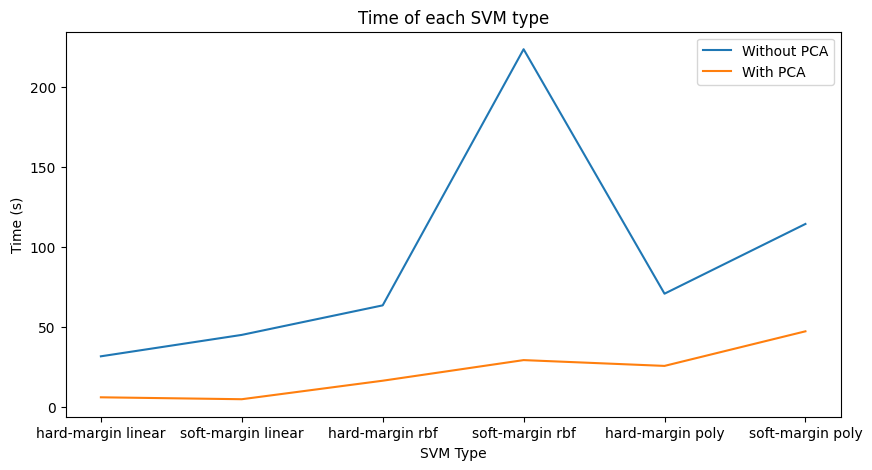

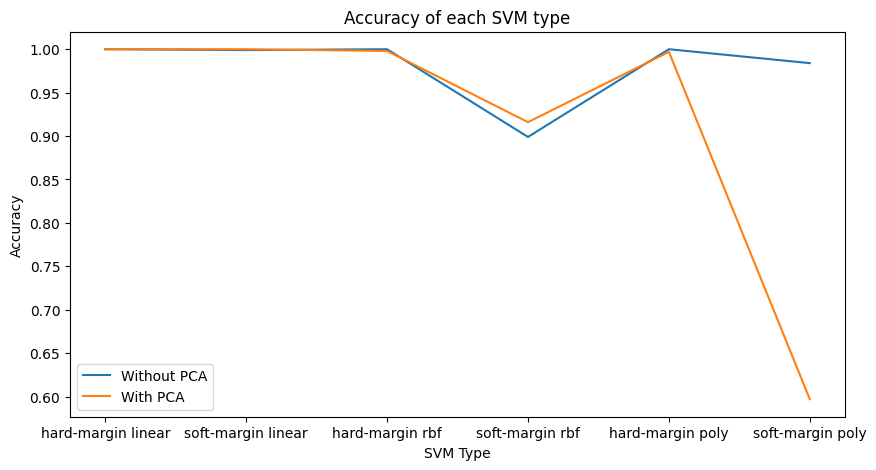

In [52]:
# plot time_acc and time_acc_PCA to compare
def plot_time_acc(time_acc, time_acc_PCA):
    """Plot the time and accuracy of each SVM type""" 
    # change time_acc[key][i] to time_acc[key][i][0] to plot time
    
    keys = time_acc.keys()
    times1 = [time_acc[key][0] for key in time_acc.keys()]
    times2 = [time_acc_PCA[key][0] for key in time_acc_PCA.keys()]
    
    # plot times1 and times2 using keys
    plt.figure(figsize=(10, 5))
    plt.plot(keys, times1, label="Without PCA")
    plt.plot(keys, times2, label="With PCA")
    plt.xlabel("SVM Type")
    plt.ylabel("Time (s)")
    plt.title("Time of each SVM type")
    plt.legend()
    plt.show()


    # plot accuracies1 and accuracies2 using keys
    accuracies1 = [time_acc[key][1] for key in time_acc.keys()]
    accuracies2 = [time_acc_PCA[key][1] for key in time_acc_PCA.keys()]
    plt.figure(figsize=(10, 5))
    plt.plot(keys, accuracies1, label="Without PCA")
    plt.plot(keys, accuracies2, label="With PCA")
    plt.xlabel("SVM Type")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of each SVM type")
    plt.legend()
    plt.show()

plot_time_acc(time_acc, time_acc_PCA)

* When we apply PCA before training the SVM classifier, computation time decreases drastically. However, there is no significant improvement in classification performance (which can be explained by the fact that we already had high accuracy results). Interestingly, we get remarkably lower accuracy results for soft-margin SVM with polynomial kernel with PCA.

In [53]:
results = [{'C': 0.1,
  'gamma': 1,
  'kernel': 'linear',
  'train_acc': 0.998,
  'val_acc': 0.996,
  'placeholder': 'something'},
 {'C': 0.1,
  'gamma': 1,
  'kernel': 'rbf',
  'train_acc': 0.125375,
  'val_acc': 0.1545,
  'placeholder': 'something'},
 {'C': 0.1,
  'gamma': 1,
  'kernel': 'poly',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 0.1,
  'gamma': 0.01,
  'kernel': 'linear',
  'train_acc': 0.998,
  'val_acc': 0.996,
  'placeholder': 'something'},
 {'C': 0.1,
  'gamma': 0.01,
  'kernel': 'rbf',
  'train_acc': 0.69175,
  'val_acc': 0.674,
  'placeholder': 'something'},
 {'C': 0.1,
  'gamma': 0.01,
  'kernel': 'poly',
  'train_acc': 0.125375,
  'val_acc': 0.1545,
  'placeholder': 'something'},
 {'C': 0.1,
  'gamma': 0.0001,
  'kernel': 'linear',
  'train_acc': 0.998,
  'val_acc': 0.996,
  'placeholder': 'something'},
 {'C': 0.1,
  'gamma': 0.0001,
  'kernel': 'rbf',
  'train_acc': 0.125375,
  'val_acc': 0.1545,
  'placeholder': 'something'},
 {'C': 0.1,
  'gamma': 0.0001,
  'kernel': 'poly',
  'train_acc': 0.125375,
  'val_acc': 0.1545,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 1,
  'kernel': 'linear',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 1,
  'kernel': 'rbf',
  'train_acc': 1.0,
  'val_acc': 0.4095,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 1,
  'kernel': 'poly',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 0.01,
  'kernel': 'linear',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 0.01,
  'kernel': 'rbf',
  'train_acc': 0.999625,
  'val_acc': 0.9985,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 0.01,
  'kernel': 'poly',
  'train_acc': 0.996125,
  'val_acc': 0.992,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 0.0001,
  'kernel': 'linear',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 0.0001,
  'kernel': 'rbf',
  'train_acc': 0.753125,
  'val_acc': 0.7315,
  'placeholder': 'something'},
 {'C': 10,
  'gamma': 0.0001,
  'kernel': 'poly',
  'train_acc': 0.125375,
  'val_acc': 0.1545,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 1,
  'kernel': 'linear',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 1,
  'kernel': 'rbf',
  'train_acc': 1.0,
  'val_acc': 0.4095,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 1,
  'kernel': 'poly',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 0.01,
  'kernel': 'linear',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 0.01,
  'kernel': 'rbf',
  'train_acc': 1.0,
  'val_acc': 0.9985,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 0.01,
  'kernel': 'poly',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 0.0001,
  'kernel': 'linear',
  'train_acc': 1.0,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 0.0001,
  'kernel': 'rbf',
  'train_acc': 0.999375,
  'val_acc': 0.998,
  'placeholder': 'something'},
 {'C': 1000,
  'gamma': 0.0001,
  'kernel': 'poly',
  'train_acc': 0.125375,
  'val_acc': 0.1545,
  'placeholder': 'something'}]